<a href="https://colab.research.google.com/github/francesco-zatto/dia-project/blob/master/car_emissions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import os.path
from urllib.request import urlretrieve

DATASETS = {
    "car_emissions_spain2022.csv": "https://raw.githubusercontent.com/pietroolivi/dia-datasets/main/car_emissions_spain2022.csv",
    "car_emissions_canada2014.csv": "https://raw.githubusercontent.com/pietroolivi/dia-datasets/main/car_emissions_canada2014/car_emissions_canada2014.csv",
    "car_emissions_uk2013.csv": "https://raw.githubusercontent.com/pietroolivi/dia-datasets/main/car_emissions_uk2013.csv"
}

for filename, dataset in DATASETS.items():
    if not os.path.exists(filename):
      urlretrieve(dataset, filename)

In [3]:
spain_emissions = pd.read_csv("car_emissions_spain2022.csv")
spain_emissions.head(5)

,id,make,model,market_segment,engine_type,consumption_min_l_100km,consumption_max_l_100km,emissions_min_gCO2_km,emissions_max_gCO2_km,transmission,...,avg_wltp_emissions_gCO2_km,length_mm,width_mm,height_mm,gross_vehicle_weight_rating_kg,total_seating,fuel_economy_index,type_hybrid,electric_consumption_kwh_100km,battery_capacity_kwh
0,551266,AIWAYS,AIWAYS U5 MAS861-WVTA/2WB/FL4,Berlinas-Familiares Medios,Eléctricos puros,NaN,NaN,NaN,NaN,A,...,0.0,4680,1865,1700,2135,5,Sin clasificación,NaN,15.75,63.0
1,579684,AIWAYS,AIWAYS U6 PRIME,Berlinas-Familiares Grandes,Eléctricos puros,NaN,NaN,NaN,NaN,A,...,0.0,4805,1880,1641,2290,5,Sin clasificación,NaN,16.00,63.0
2,464453,ALKE,ALKE ATX 310 E plomo acido,Chasis-Cabina Pequeño,Eléctricos puros,NaN,NaN,NaN,NaN,SC,...,0.0,3030,1500,2000,1510,2,Sin clasificación,NaN,11.00,10.0
3,464454,ALKE,ALKE ATX 320 E plomo acido,Chasis-Cabina Pequeño,Eléctricos puros,NaN,NaN,NaN,NaN,SC,...,0.0,3850,1500,2000,1510,2,Sin clasificación,NaN,11.00,10.0
4,464455,ALKE,ALKE ATX 330 E plomo acido,Chasis-Cabina Pequeño,Eléctricos puros,NaN,NaN,NaN,NaN,SC,...,0.0,3850,1500,2000,1510,2,Sin clasificación,NaN,11.00,10.0


In [4]:
canada_emissions = pd.read_csv("car_emissions_canada2014.csv")
canada_emissions.head(5)

,_id,Model year,Make,Model,Vehicle class,Engine size (L),Cylinders,Transmission,Fuel type,City (L/100 km),Highway (L/100 km),Combined (L/100 km),Combined (mpg),CO2 emissions (g/km)
0,1,1995,Acura,Integra,Subcompact,1.8,4,A4,X,10.2,7.0,8.8,32,202
1,2,1995,Acura,Integra,Subcompact,1.8,4,M5,X,9.6,7.0,8.4,34,193
2,3,1995,Acura,Integra GS-R,Subcompact,1.8,4,M5,Z,9.4,7.0,8.3,34,191
3,4,1995,Acura,Legend,Compact,3.2,6,A4,Z,12.6,8.9,10.9,26,251
4,5,1995,Acura,Legend Coupe,Compact,3.2,6,A4,Z,13.0,9.3,11.3,25,260


In [5]:
uk_emissions = pd.read_csv("car_emissions_uk2013.csv")
uk_emissions.head(5)

C:\Users\franc\AppData\Local\Temp\ipykernel_24692\3678210660.py:1: DtypeWarning: Columns (6,30) have mixed types. Specify dtype option on import or set low_memory=False.
  uk_emissions = pd.read_csv("car_emissions_uk2013.csv")


,file,year,manufacturer,model,description,euro_standard,tax_band,transmission,transmission_type,engine_capacity,...,nox_emissions,thc_nox_emissions,particulates_emissions,fuel_cost_12000_miles,fuel_cost_6000_miles,standard_12_months,standard_6_months,first_year_12_months,first_year_6_months,date_of_change
0,DatapartC_july2000.csv,2000,Alfa Romeo,145 Range,1.6 Twin Spark 16v,2,NaN,M5,Manual,1598.0,...,NaN,NaN,NaN,NaN,618.0,NaN,NaN,NaN,NaN,NaN
1,DatapartC_july2000.csv,2000,Alfa Romeo,145 Range,1.8 Twin Spark 16v,2,NaN,M5,Manual,1747.0,...,NaN,NaN,NaN,NaN,633.0,NaN,NaN,NaN,NaN,NaN
2,DatapartC_july2000.csv,2000,Alfa Romeo,145 Range,Cloverleaf,2,NaN,M5,Manual,1970.0,...,NaN,NaN,NaN,NaN,663.0,NaN,NaN,NaN,NaN,NaN
3,DatapartC_july2000.csv,2000,Alfa Romeo,146 Range,1.6 Twin Spark 16v,2,NaN,M5,Manual,1598.0,...,NaN,NaN,NaN,NaN,626.0,NaN,NaN,NaN,NaN,NaN
4,DatapartC_july2000.csv,2000,Alfa Romeo,146 Range,1.8 Twin Spark 16v,2,NaN,M5,Manual,1747.0,...,NaN,NaN,NaN,NaN,633.0,NaN,NaN,NaN,NaN,NaN


# **Esplorazione dei singoli dataset**

## Esplorazione del dataset `spain_emissions`

### Rimozione delle righe riguardanti veicoli elettrici

All'interno del dataset proveniente dal ministero spagnolo sono presenti anche dati riguardanti macchine elettriche. Questa tipologia di dato non è interessante per l'obiettivo del modello, ovvero la quantità di CO<sub>2</sub> emessa.

La cella seguente analizza i valori delle righe che hanno `engine_type` "Eléctricos puros", estraendo solo le colonne sul minimo e massimo di consumo di litri di carburante e sul minimo e massimo di emissioni di CO<sub>2</sub> per km percorso.

In [6]:
columns = ["emissions_min_gCO2_km", "emissions_max_gCO2_km"]
spain_emissions.loc[spain_emissions["engine_type"] == "Eléctricos puros", columns].isna().all()

emissions_min_gCO2_km    True
emissions_max_gCO2_km    True
dtype: bool

Come era previdibile, tutti i valori delle emissioni di CO<sub>2</sub> per km nelle righe riguardanti i veicoli elettrici sono mancanti, quindi le rispettive righe possono essere eliminate, poichè non utili per l'addestramento del modello, il cui obiettivo è la previsione dell'emissione di CO<sub>2</sub> per veicoli a motore termico.

In [7]:
electric_cars_index = spain_emissions.loc[spain_emissions["engine_type"] == "Eléctricos puros"].index
spain_emissions = spain_emissions.drop(electric_cars_index)
spain_emissions["engine_type"].unique()

array(['Gasolina', 'Gasóleo', 'Híbridos enchufables',
       'Híbridos de gasolina', 'Gas natural', 'Híbridos de gasóleo',
       'Gases licuados del petróleo (GLP)', 'Pila de combustible',
       'Autonomía extendida'], dtype=object)


Come si può notare dall'output della cella precedente, la colonna `engine_type` non contiene il valore "Eléctricos puros".

### Rimozione delle colonne contenenti solo valori `NaN`
Nel dataset dell'emissioni di CO<sub>2</sub> proveniente dalla Spagna la colonne `type_hybrid`, `electric_consumption_kwh_100km`, `battery_capacity_kwh ` contengono solo valori `NaN`.

In [8]:
all_nan_columns = ["type_hybrid", "electric_consumption_kwh_100km", "battery_capacity_kwh"]
spain_emissions[all_nan_columns].isna().values.all()

True

In [9]:
spain_emissions = spain_emissions.drop(all_nan_columns, axis=1)

### Rimozione delle righe senza un valore valido di trasmissione
La colonna `transmission` contiene il tipo di trasmissione del veicolo, quindi la modalità di cambio della marcia, se automatica o manuale, che nella colonna sono rispettivamente "A" e "M". L'output della prossima cella mostra che sono presenti 35 righe con valori di trasmissioni non validi, poichè nel dataset spagnolo "SC" sta per "Sin clasificasion", ovvero non classificato. Perciò le righe con valori di trasmissione non validi, essendo un numero molto ridotto, verrano eliminate.

In [10]:
spain_emissions["transmission"].value_counts()

A     7735
M     7337
SC      33
0        2
Name: transmission, dtype: int64

In [11]:
valid_transmissions = spain_emissions["transmission"].isin(["A", "M"])
spain_emissions["transmission"] =  spain_emissions.loc[valid_transmissions, "transmission"]

# **Omogeneizzazione ed unione dei dati**
Avendo reperito tre set di dati ciascuno da una fonte differente, sebbene questi concernano il medesimo dominio e condividano pertanto una considerevole quantità di attributi,

Potremmo essere erroneamente portati a compiere un troncamento delle colonne, conservando esclusivamente quelle appartenenti all'intersezione delle tre tabelle, tuttavia così facendo andremmo a trascurare il caso-limite in cui le features eliminate dovessero essere le uniche legate, attraverso un relazione non randomica, a quella indagata. Una soluzione più scrupolosa consisterebbe, al contrario, nell'unione degli attributi, colmando opportunamente le celle vuote formatesi. In effetti, come visto a lezione, i valori NAN possono essere sostituiti, tra gli altri, da:
- media
- moda
- mediana

In aggiunta, le stesse variabili in comune, malgrado facciano riferimento allo stesso concetto, si manifestano talvolta sotto denominazioni diverse, ed a loro volta i valori corrispondenti da queste assunti potrebbero avere formato dissimile (e.g. capitalizzazione delle lettere nel caso testuale o numero di cifre significative in quello numerico).







## Omogeneizzazione di `spain_emissions`

### Traduzione spagnolo-inglese 
Il dataset proveniente dalla Spagna contiene due colonne in spagnolo, `engine_type` e `market_segment`. Quindi è necessaria una traduzione dallo spagnolo all'inglese per entrambe le colonne, così da adattarle agli altri due dataset.

Definisco una funzione per sostituire i valori di una colonna di un dataframe con dei nuovi valori passati come argomento, in questo caso la rispettiva traduzione in inglese, tramite una funzione di mapping fornita da pandas.

In [12]:
def get_column_mapped_values(column, new_values):
    mapping = dict(zip(column.unique(), new_values))
    return column.map(mapping)

In [13]:
#Traduzione della colonna engine_type
spanish_engine_type = spain_emissions["engine_type"].unique()
english_engine_type = ["Petrol", "Diesel", "Plug-in hybrid", "Petrol hybrid", "Natural gas", 
                       "Diesel Hybrid", "Liquefied petroleum gas(LPG)", "Fuel cell", "Extended range"]

spain_emissions["engine_type"] = get_column_mapped_values(spain_emissions["engine_type"], english_engine_type)

Per la traduzione della colonna `market_segment` si fa riferimento al dataset canadese, il quale contiene una colonna per la classificazione dei veicoli, `Vehicle class`.


In [14]:
canada_emissions["Vehicle class"].unique()

array(['Subcompact', 'Compact', 'Two-seater', 'Station wagon: Small',
       'Minicompact', 'Mid-size', 'Full-size', 'Station wagon: Mid-size',
       'Van: Cargo', 'Van: Passenger', 'Pickup truck: Standard',
       'Sport utility vehicle', 'Minivan', 'Pickup truck: Small',
       'Special purpose vehicle', 'Sport utility vehicle: Small',
       'Sport utility vehicle: Standard'], dtype=object)

In [15]:
#Traduzione della colonna market_segment
english_market_segment = ["Minicompact", "Compact", "Small off-road", "Mid-size", "Sport utility vehicle", "Full-size", 
                          "Mid-size off-road", "Full-size off-road", "Minivan", "Luxury", "Minivan", "Van: Passenger"] \
                        + (["Van: Cargo"] * 2) + (["Lorry"] * 7)

spain_emissions["market_segment"] = get_column_mapped_values(spain_emissions["market_segment"], english_market_segment)

### Calcolo medie del consumo di carburante e delle emissioni di CO<sub>2</sub>
Sia per il consumo di carburante che per le emissioni di CO<sub>2</sub> sono presenti i valori di minimo, di massimo e la media
WLTP (<i>Worldwide harmonized Light vehicles Test Procedure</i>), ovvero le misure ottenute dal test standard a livello mondiale per il controllo delle emissioni e dei consumi dei veicoli.
Da questi tre valori ne verrà calcolata la media così da avere una sola colonna per i consumi di carburante e una sola colonna per i consumi di CO<sub>2</sub>, la variabile target da predire.

Prima di poter precedere è necessario controllare che in tutte le righe del dataframe sia presente almeno uno dei tre valori richiesti e che sia diverso da 0, sia per calcolare la media del consumo che delle emissioni.
<br>Nella cella successiva si può vedere esattamente in quante righe sono mancanti questi valori necessari.

In [16]:
def isnaOrIsZero(dataframe):
    return dataframe.isna() | dataframe.eq(0)

In [17]:
consumption_columns = ["consumption_min_l_100km", "consumption_max_l_100km", "avg_wltp_consumption_l_100km"]
emissions_columns = ["emissions_min_gCO2_km", "emissions_max_gCO2_km", "avg_wltp_emissions_gCO2_km"]

rows_no_consumption = isnaOrIsZero(spain_emissions[consumption_columns]).all(axis=1)
number_rows_missing_consumption = rows_no_consumption.sum()
print("Rows with no consumption_l_100km:", number_rows_missing_consumption)

rows_no_emissions = isnaOrIsZero(spain_emissions[emissions_columns]).all(axis=1)
number_rows_missing_emissions = rows_no_emissions.sum()
print("Rows with no emissions_gCO2_km:", number_rows_missing_emissions)

rows_no_emissions_consumptions = (rows_no_consumption & rows_no_emissions)
number_rows_missing_emissions_consumptions = rows_no_emissions_consumptions.sum()
print("Rows with no emissions_gCO2_km and no consumption_l_km:", number_rows_missing_emissions_consumptions)

Rows with no consumption_l_100km: 1560
Rows with no emissions_gCO2_km: 1562
Rows with no emissions_gCO2_km and no consumption_l_km: 1560


Come riportato nell'output della cella precedente, ci sono <strong>1560</strong> righe senza alcun valore di consumo di carburante, <strong>1562</strong> righe senza alcun valore di emissioni di CO<sub>2</sub> e <strong>1560</strong> in cui è assente sia il consumo di carburante che le emissioni di CO<sub>2</sub>. <br> 
Nella cella successiva vengono calcolate le medie di carburante ed emissioni di ciascuna riga e vengono inserite in due nuove colonne `consumption_l_100km`, `emissions_gCO2_km`. <br>

In [18]:
mean_consumption = "consumption_l_100km"
mean_emissions = "emissions_gCO2_km"
spain_emissions[mean_consumption] = spain_emissions[consumption_columns].mean(axis=1)
spain_emissions[mean_emissions] = spain_emissions[emissions_columns].mean(axis=1)

In [19]:
spain_emissions = spain_emissions.drop(consumption_columns + emissions_columns, axis=1)

Quindi vengono sostituiti i valori mancanti e i valori posti a 0, poichè considerati anch'essi mancanti, siccome le categorie di veicoli considerate dovrebbero presentare dei consumi di carburante e delle emissioni di CO<sub>2</sub> positivi. <br>
La cella successiva mostra le categorie di veicoli in cui sono assenti sia i consumi di carburante che le emissioni. Le due categorie con più occorrenze sono i "Van: Cargo" e "Lorry", due mezzi molto pesanti e con valori differenti rispetto ad altre categorie, quindi sarebbe più corretto riempire i valori assenti o posti a 0, con i mediani delle due rispettive categorie. Mentre per le restanti categorie si può utilizzare direttamente il mediano di tutta la colonna.

In [20]:
most_missing_market_segments = spain_emissions.loc[rows_no_emissions_consumptions, "market_segment"].value_counts()[:5]
most_missing_market_segments

Van: Cargo            1202
Lorry                  327
Luxury                  15
Full-size off-road       9
Van: Passenger           3
Name: market_segment, dtype: int64

Le celle successive evidenziano la necessità di usare, come valore per riempire i valori NaN o posti a 0 delle categorie di veicoli "Van: Cargo" e "Lorry", i rispettivi mediani, anzichè usare direttamente il mediano di tutta la colonna, vista l'ampia differenza causata dalla presenza di veicoli di diverse dimensioni e consumi.

In [21]:
columns = [mean_consumption, mean_emissions]
market_segments = ["Van: Cargo", "Lorry"]

In [22]:
all_median = pd.DataFrame(spain_emissions[columns].median(), columns = ["All"]).T
van_cargo_lorries = spain_emissions.loc[spain_emissions["market_segment"].isin(market_segments), ["market_segment"] + columns]
van_cargo_lorries_median = van_cargo_lorries[van_cargo_lorries.ne(0)].groupby("market_segment").median()

In [23]:
pd.concat([all_median, van_cargo_lorries_median]).style.set_caption("Market segments medians")

,consumption_l_100km,emissions_gCO2_km
All,6.000000,141.000000
Lorry,7.900000,203.333333
Van: Cargo,7.950000,196.083333


In [24]:
def fillnaZeroes(market_segment, columns):
    vehicles = spain_emissions.loc[spain_emissions["market_segment"] == market_segment, columns].replace(0, np.nan)
    vehicles = vehicles.fillna(vehicles.median())
    return vehicles

In [25]:
for market_segment in market_segments:
    spain_emissions.loc[spain_emissions["market_segment"] == market_segment, columns] = fillnaZeroes(market_segment, columns)

In [26]:
other_market_segments = set(spain_emissions["market_segment"].unique()) - set(market_segments)
spain_emissions[columns] = spain_emissions[columns].replace(0, np.nan).fillna(spain_emissions[columns].median())

### Utilizzo di valori espliciti per il tipo di trasmissione
Il dataset spagnolo per indicare la tipologia di trasmissione utilizza solamente "A" e "M". Per adattarlo agli altri dataset e per renderlo più chiaro si è deciso di mappare i rispettivi valori con la versione estesa, ovvero "Automatic", "Manual".

In [27]:
renaming_dict = {"A": "Automatic", "M": "Manual"}
spain_emissions["transmission"] = spain_emissions["transmission"].map(renaming_dict)

### Inserimento dell'anno del modello del veicolo
I dataset canadesi e britannici presentano entrambi una colonna per l'anno del modello(`Model year` in `canada_emissions` e `year` in `uk_emissions`), una feature che può essere importante per la predezioni delle emissioni prodotte. Quindi a partire dagli altri due dataset, viene estratta la colonna dell'anno.

Prima di procedere all'inserimento è necessario un adattamento della colonna `model`, poichè nel dataset `spain_emissions` ciascun valore è formato dal nome della casa automobilistica, ovvero il valore della colonna `make`, dal nome effettivo del modello e da altre informazioni aggiuntive sul modello. Quindi, si procede all'eliminazione della casa automobilistica e delle informazioni aggiuntive per adattarlo alla colonna del modello degli altri due dataset.

La prossime due celle rimuovono suffissi non presenti negli altri due dataset, eliminando le parole contenute nella variabile locale `useless_words`.

In [28]:
useless_words = {"Canarias", "Vehículos", "Turismos", "Comerciales", "Nuevo", "NUEVO", "Turismos"}
# Per rimuovere suffissi fuorvianti, non presenti negli altri dataset, nei nomi delle case automobilistiche
def remove_useless_suffix(make):
    make_words = make.split()
    make_words = set(make_words) - useless_words
    return " ".join(make_words)

In [29]:
spain_emissions["make"] = spain_emissions["make"].apply(remove_useless_suffix)

Di seguito, l'adattamento del nome del modello eliminando la casa automobilistica e le informazioni aggiuntive.

In [30]:
# Per rimuovere il nome della casa automobilistica e le informazioni aggiuntive dal nome del modello
def remove_manufacturer_and_addional_info(make_model):
    make = make_model["make"]
    model = make_model["model"]
    removedManufacturer = model.replace(make, "").split()
    model = [word for word in removedManufacturer if word not in useless_words][0]
    return model

In [31]:
spain_emissions["model"] = spain_emissions[["make", "model"]].apply(remove_manufacturer_and_addional_info, axis=1)

Dopo l'adattamento del nome della casa automobilistica e del nome del modello del veicolo, si può procedere all'effettivo inserimento dell'anno in base ai valori dell'anno nei dataset `uk_emissions` e `canada_emissions`. I valori dell'anno che risultano non presenti a seguito del join con `uk_emissions` verranno prelevati dal secondo dataset `canada_emissions`. In caso dei valori risultassero ancora mancanti, tali righe verranno scartate dal dataset, poichè prive di un'informazione rilevante ai fini dell'addestramento del modello.

In [32]:
spain_emissions = (
    pd.merge(
        spain_emissions,
        uk_emissions[["manufacturer", "model", "year"]],
        how = "left",
        left_on = ["make", "model"],
        right_on =  ["manufacturer", "model"]
    )
    .drop_duplicates()
)[list(spain_emissions.columns) + ["year"]]

In [33]:
spain_emissions_year_na = spain_emissions[spain_emissions["year"].isna()].drop("year", axis=1)
spain_emissions_year_canada = (
    pd.merge(
        spain_emissions_year_na,
        canada_emissions[["Make", "Model", "Model year"]],
        how = "left",
        left_on = ["make", "model"],
        right_on =  ["Make", "Model"]
    )
    .drop_duplicates()
    .rename(columns = {"Model year": "year"})
)[list(spain_emissions.columns)]

La cella a seguire inserisce i valori dell'anno ottenuti dal join con `canada_emissions` al posto dei valori mancanti a seguito del join con `uk_emissions`. Infine, le righe in cui la colonna `year` risulta ancora mancante dopo i due join verranno scartate.   

In [34]:
spain_emissions["year"] = spain_emissions["year"].fillna(spain_emissions_year_canada["year"])
spain_emissions = spain_emissions.dropna()

### Grafici di `spain_emissions`
Questa sezione contiene alcuni grafici che evidenziano alcuni aspetti del dataframe risultante `spain_emissions`.value_countsunique

L'istogramma seguente mostra la distribuzione delle emissioni di CO<sub>2</sub> nel dataset spagnolo. I valori si concentrano principalmente nell'intervallo [100, 200].

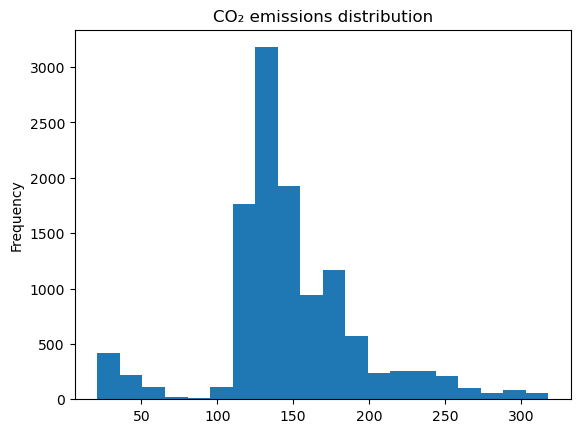

In [35]:
spain_emissions["emissions_gCO2_km"].plot.hist(bins=20,title="CO\u2082 emissions distribution");

Il seguente grafico mostra la correlazione tra il consumo di carburante e le emissioni di CO<sub>2</sub>. Si evince che esiste una dipendenza tra i due valori, fatta eccezione per alcuni punti. 

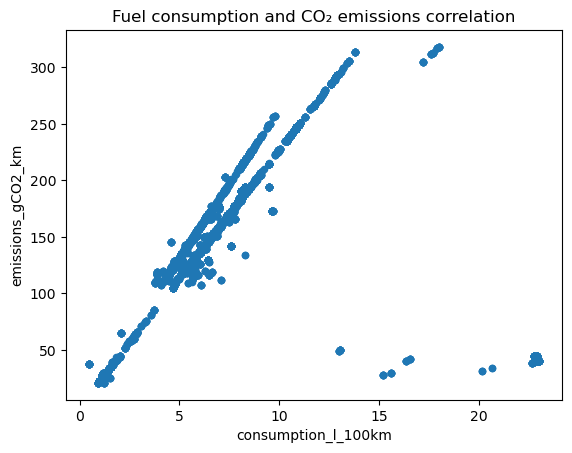

In [36]:
spain_emissions.plot.scatter("consumption_l_100km", "emissions_gCO2_km", title="Fuel consumption and CO\u2082 emissions correlation");

Nel grafico a torta è rappresentata la distribuzione delle categorie di veicoli. Una metà è occupata da sole 4 categorie, mentre le altre 9 si spartiscono il restante 50%.

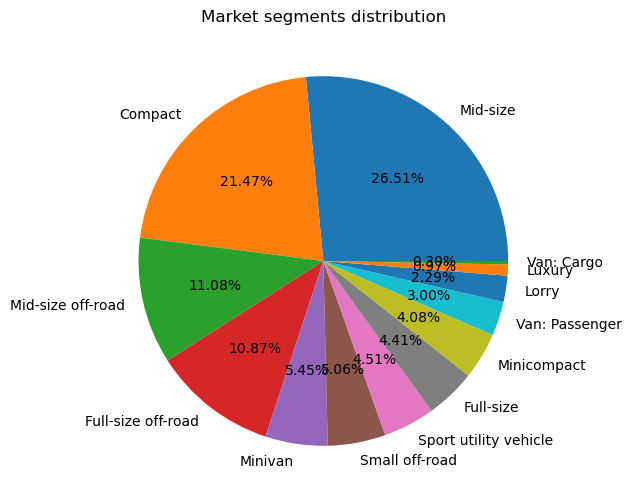

In [37]:
spain_emissions["market_segment"].value_counts().plot.pie(autopct="%.2f%%", title="Market segments distribution", label="", figsize=(6,6));

Nel seguente grafico è mostrata la relazione tra ciascuna categoria di veicoli e le emissioni di CO<sub>2</sub> corrispondenti. Sono presenti molti outlier sia nella parte inferiore che nella parte superiore di ciascun boxplot. Si può notare come i le medie dei valori di veicoli più pesanti e più inquinanti come "Lorry", "Van: Cargo" e "Luxury" siano molto più alti delle medie dei valori corrispondenti ai veicoli più leggeri e meno inquinanti come "Compact", "Minicompact" e "Mid-size". Questa osservazione è vera solo per le medie e i mediani, siccome i valori di ciascun boxplot coprono una buona parte dell'asse y, quindi alcuni veicoli "Compact" hanno valori più alti di alcuni "Lorry".

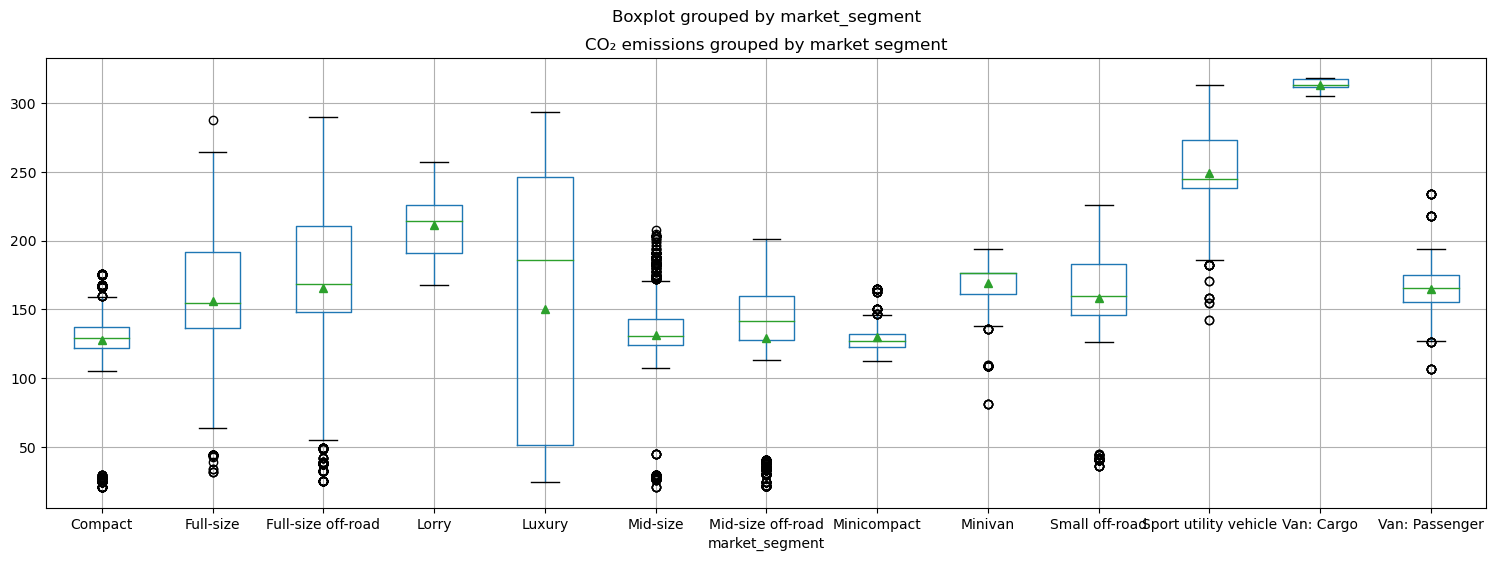

In [38]:
spain_emissions.boxplot(column="emissions_gCO2_km", by="market_segment", showmeans=True, figsize=(18, 6)).set_title("CO\u2082 emissions grouped by market segment");

Mentre nel grafico successivo vengono mostrati gli stessi valori, ma in relazione alla tipologia di motore. Quasi tutti boxplot hanno i valori di media e mediana che si assestano tra 150 e 200, presentando però anche in questo caso molti outlier.

### Titolo da definire (scartare colonne non necessarie)
Questa ultima parte dell'omogeneizzazione di `spain_emissions` seleziona solo le colonne utilizzate nell'addestramento rinominandole e facendo le ultime modifiche ai valori delle colonne, in modo da utilizzare uno standard comune agli altri dataset.

In [39]:
old_columns = ["year", "make", "model", "engine_displacement_cm3", "consumption_l_100km", "engine_type", "emissions_gCO2_km", "transmission"] 
new_columns = ["Year", "Manufacturer", "Model", "Engine_cm3", "Fuel_consumption", "Fuel_type", "CO2_emissions", "Transmission_type"]
columns_dict = dict(zip(old_columns, new_columns))

In [40]:
spain_emissions = spain_emissions[old_columns].rename(columns = columns_dict)

Da questo punto in poi, Liquefied Petroleum Gas (LPG) verrà semplicemente sostituito con LPG.

In [41]:
spain_emissions["Fuel_type"] = spain_emissions["Fuel_type"].replace("Liquefied petroleum gas(LPG)", "LPG")

Infine, per i contenuti di tipo stringa come `Manufacturer` e `Model`, sarà necessaria una standardizzazione tra i diversi dataset. Lo standard scelto è la maiuscola per il primo carattere e la minuscola per gli altri caratteri.

In [42]:
capitalize_columns = ["Manufacturer", "Model"]
for col in capitalize_columns:
    spain_emissions[col] = spain_emissions[col].str.capitalize()